# Prédire l'interaction molécule - protéine pour la découverte de médicaments
Rachid Sahli - rachidsahli144@outlook.fr

### Import des données 

Les données utilisées sont extraites de la base [ChEMBL](https://www.ebi.ac.uk/chembl/).

In [1]:
# Import librairies ----
## Algèbre linéaire et manipulation de données
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Viasualisaton moléculaire
import py3Dmol

## RDKit
import rdkit 
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import Draw

## Machine learning
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# Import data ----
train = pd.read_csv('data/x_train.csv')
test = pd.read_csv('data/x_test.csv')

y_train = pd.read_csv('data/y_train.csv')['y']

print(f"Le dataset d'entraînement contient {train.shape[0]} molécules.")
print(f"le dataset de test contient {test.shape[0]} molécules.")

train.head()

Le dataset d'entraînement contient 4400 molécules.
le dataset de test contient 2934 molécules.


,id,smiles
0,0,CNC(=O)c1ccccc1Sc1ccc2c(C#Cc3cccc(NCCOC)c3)n[n...
1,1,CC(C)(C)c1ccc(Nc2nnc(-c3cnccc3CCc3ccncc3)o2)cc1
2,2,CN1CCN(CCCn2ccc(-c3cnc4c(-c5ccsc5)cnn4c3)cc2=O...
3,3,CCn1c2ccc(NC(=O)Nc3ccc(OC)cc3)cc2c2c3c(c4c(c21...
4,4,Cc1ccc(C(=O)Nc2cccc(C(C)C)c2)cc1N1CCc2ncncc2C1


Les molécules sont au format SMILES. Afin de pouvoir les manipuler avec la librairie rdkit, nous les convertissons au format
'Mol'

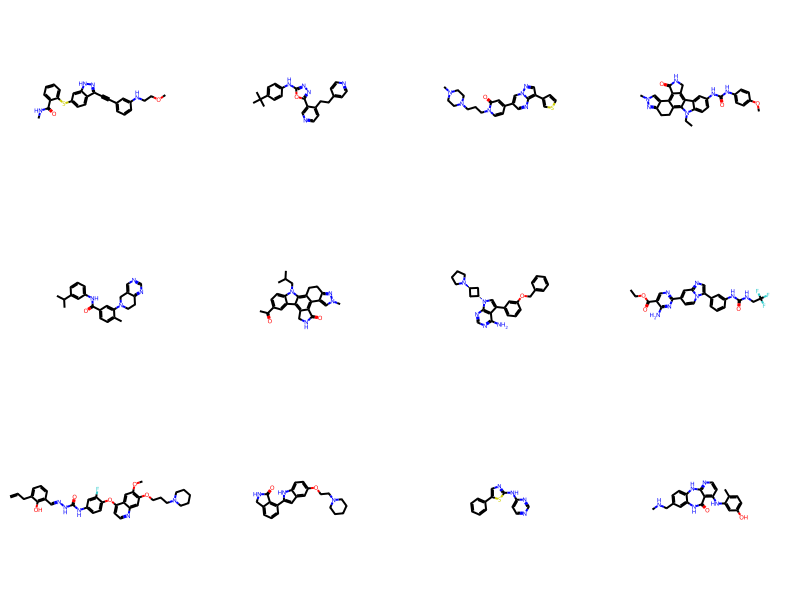

In [3]:
mol = train.smiles.apply(Chem.MolFromSmiles)
Draw.MolsToGridImage(mol[:12],molsPerRow=4)

In [4]:
# Convertion
train_mols = [AllChem.MolFromSmiles(smile) for smile in train['smiles']]
test_mols = [AllChem.MolFromSmiles(smile) for smile in test['smiles']]

print(type(train_mols[0]))

<class 'rdkit.Chem.rdchem.Mol'>


### Visualisation des molécules

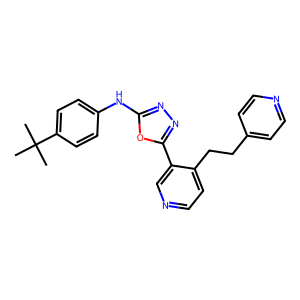

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [5]:
index = 1  # Index de la molécule
mol = train_mols[index]
img = Draw.MolToImage(mol)
display(img) # Affichage de la molécule

# Affichage en 3D
view = py3Dmol.view(width=450, height=400)
mol = train_mols[index]  
mol_block = Chem.MolToMolBlock(mol)
view.addModel(mol_block, "mol")
view.setStyle({"stick": {}})
view.zoomTo()
view.show()

### Calcul des empreintes moléculaires (fingerprints)

Les fingerprints sont des vecteurs binaires qui capturent la présence ou l'absence de caractéristiques chimiques spécifiques, telles que les groupes fonctionnels, les types d'atomes, les liaisons ou les propriétés moléculaires. C'est une manière courante d'encoder l'information contenue dans une molécule. On convertit donc nos molécules intialement stockées au format SMILES en fingerprints. 

In [6]:
# Convertion de Mol à Fingerprints
morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)
train_fps = np.array([morgan_gen.GetFingerprint(mol) for mol in train_mols])
test_fps = np.array([morgan_gen.GetFingerprint(mol) for mol in test_mols])

print(f"Le dataset d'entraînement contient {train_fps.shape[0]} molécules encodées avec {train_fps.shape[1]} bits.")
print(f"Le  dataset de test contient {test_fps.shape[0]} molécules encodées avec  {test_fps.shape[1]} bits.")

Le dataset d'entraînement contient 4400 molécules encodées avec 2048 bits.
Le  dataset de test contient 2934 molécules encodées avec  2048 bits.


Nos deux jeux de données contiennent à présent des molécules qui sont des vecteurs binaires de 2048 bits chacun.

In [7]:
# Molécules
pd.DataFrame(train_fps).head()
pd.DataFrame(test_fps).head() 

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Valeur de pIC50
pd.DataFrame(y_train).head() 

,y
0,7.882729
1,6.508498
2,8.148742
3,7.954677
4,7.954677


### Machine learning

Maintenant, que nous disposons des données, nous pouvons entraîner des modèles d'apprentissage sur celle-ci.

In [9]:
X_train = train_fps
X_test = test_fps

On divise nos données en un ensemble d'entraînement (80 % des données) et un ensemble de test (20 % des données).

In [10]:
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"Dimensions de X_train_split : {X_train_split.shape}")
print(f"Dimensions de X_test_split : {X_test_split.shape}")

Dimensions de X_train_split : (3520, 2048)
Dimensions de X_test_split : (880, 2048)


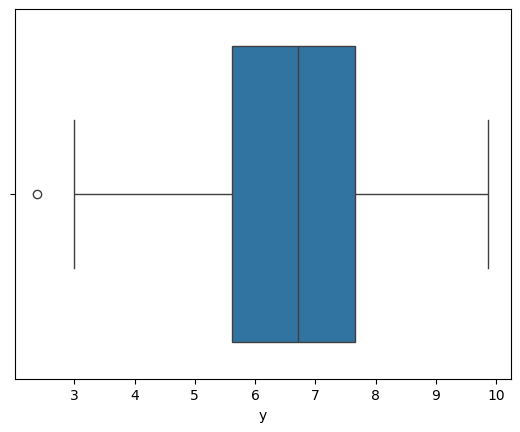

In [11]:
# Visualisation des valeurs cibles
sns.boxplot(x=y_train)
plt.show()

#### Forêt aléatoire

Nous commençons par implémenter un modèle de forêt aléatoire avec les paramètres par défaut. Nous utilisons la validation croisée pour "estimer" la vrai performance de notre modèle sur des données jamais observée.

In [12]:
model = RandomForestRegressor(n_jobs=-1, random_state=42)
cv = cross_validate(estimator=model, 
                    X=X_train_split, 
                    y=y_train_split, 
                    cv=5, 
                    scoring=["neg_median_absolute_error", "neg_root_mean_squared_error"],
                    n_jobs=-1,
                    verbose=0)

print(f"Scores de validation croisée pour MAE : {-cv['test_neg_median_absolute_error'].mean():.4f}")
print(f"Scores de validation croisée pour RMSE : {-cv['test_neg_root_mean_squared_error'].mean():.4f}")

Scores de validation croisée pour MAE : 0.4459
Scores de validation croisée pour RMSE : 0.8123


#### Arbre CART

In [13]:
model = DecisionTreeRegressor(random_state=42)
cv = cross_validate(estimator=model, 
                    X=X_train_split, 
                    y=y_train_split, 
                    cv=5, 
                    scoring=["neg_median_absolute_error", "neg_root_mean_squared_error"],
                    n_jobs=-1,
                    verbose=0)
print(f"Scores de validation croisée pour MAE : {-cv['test_neg_median_absolute_error'].mean():.4f}")
print(f"Scores de validation croisée pour RMSE : {-cv['test_neg_root_mean_squared_error'].mean():.4f}")

Scores de validation croisée pour MAE : 0.4704
Scores de validation croisée pour RMSE : 1.1052


#### KNN

In [14]:
model = KNeighborsRegressor()
cv = cross_validate(estimator=model, 
                    X=X_train_split, 
                    y=y_train_split, 
                    cv=5, 
                    scoring=["neg_median_absolute_error", "neg_root_mean_squared_error"],
                    n_jobs=-1,
                    verbose=0)
print(f"Scores de validation croisée pour MAE : {-cv['test_neg_median_absolute_error'].mean():.4f}")
print(f"Scores de validation croisée pour RMSE : {-cv['test_neg_root_mean_squared_error'].mean():.4f}")

Scores de validation croisée pour MAE : 0.4723
Scores de validation croisée pour RMSE : 0.8589


### Optimisation du modèle de forêt aléatoire

On entraîne le modèle puis on le test sur les données d'entraînement.

In [15]:
model.fit(X_train_split, y_train_split)

KNeighborsRegressor()

In [16]:
# Prédicition sur les données d'entraînement
y_pred_train = model.predict(X_train_split)

In [53]:
mae_train = mean_absolute_error(y_train_split, y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train_split, y_pred_train))

print(f"MAE (train) : {mae_train:.4f}")
print(f"RMSE (train) : {rmse_train:.4f}")

MAE (train) : 0.2152
RMSE (train) : 0.2949


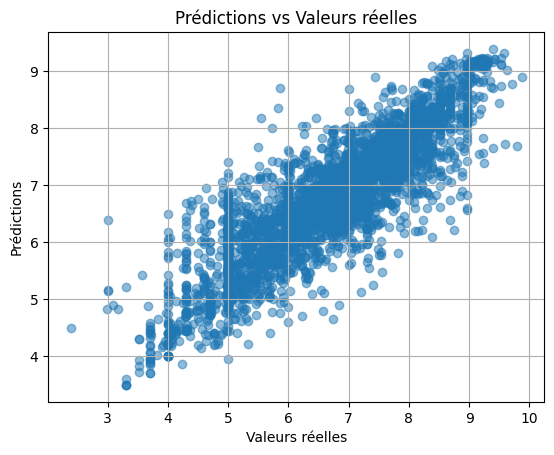

In [17]:
# Visualisation des prédictions
plt.scatter(y_train_split, y_pred_train, alpha=0.5)
plt.xlabel("Valeurs réelles")
plt.ylabel("Prédictions")
plt.title("Prédictions vs Valeurs réelles")
plt.grid(True)
plt.show()

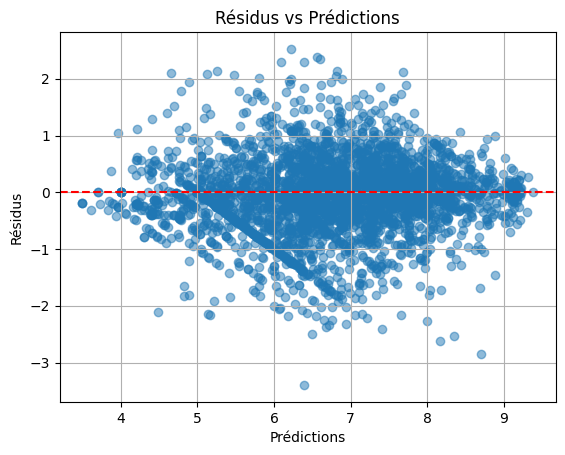

In [18]:
# Visualisation des résidus
residuals = y_train_split - y_pred_train
plt.scatter(y_pred_train, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Prédictions")
plt.ylabel("Résidus")
plt.title("Résidus vs Prédictions")
plt.grid(True)
plt.show()

On obtient une MAE assez faible sur le dataset d'entraînement.

In [19]:
# Prédiction sur les données de test
y_pred_test = model.predict(X_test_split)

In [57]:
mae_test = mean_absolute_error(y_test_split, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test_split, y_pred_test))

print(f"MAE (test) : {mae_test:.4f}")
print(f"RMSE (test) : {rmse_test:.4f}")

MAE (test) : 0.5792
RMSE (test) : 0.7893


On obtient une MAE beaucoup plus élevé. Un sur-ajustement du modèle aux données d'entraînement peut être la cause de cet écart.

#### Bagging

Maintenant, nous allons construire un prédicteur de type bagging composé de 500 arbres.

In [20]:
# Initialisation du modèle
base_model = DecisionTreeRegressor(random_state=42)

bagging_model = BaggingRegressor(base_model, 
                                n_estimators=500,
                                random_state=42, 
                                n_jobs=-1) 

bagging_model.fit(X_train_split, y_train_split)

BaggingRegressor(estimator=DecisionTreeRegressor(random_state=42),
                 n_estimators=500, n_jobs=-1, random_state=42)

In [21]:
# Prédictions sur les deux dataset
y_pred_train_bagging = bagging_model.predict(X_train_split)
y_pred_test_bagging = bagging_model.predict(X_test_split)

In [22]:
# Évaluation du modèle
mae_train_bagging = mean_absolute_error(y_train_split, y_pred_train_bagging)
rmse_train_bagging = np.sqrt(mean_squared_error(y_train_split, y_pred_train_bagging))
mae_test_bagging = mean_absolute_error(y_test_split, y_pred_test_bagging)
rmse_test_bagging = np.sqrt(mean_squared_error(y_test_split, y_pred_test_bagging))

print(f"MAE (train) : {mae_train_bagging:.4f}")
print(f"RMSE (train) : {rmse_train_bagging:.4f}")
print(f"MAE (test) : {mae_test_bagging:.4f}")
print(f"RMSE (test) : {rmse_test_bagging:.4f}")

MAE (train) : 0.2120
RMSE (train) : 0.2888
MAE (test) : 0.5770
RMSE (test) : 0.7866


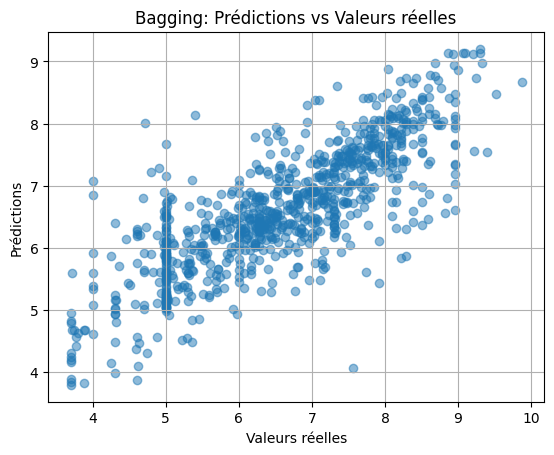

In [23]:
# Visualisation des prédictions sur le dataset de test
plt.scatter(y_test_split, y_pred_test_bagging, alpha=0.5)
plt.xlabel("Valeurs réelles")
plt.ylabel("Prédictions")
plt.title("Bagging: Prédictions vs Valeurs réelles")
plt.grid(True)
plt.show()